In [1]:
import pandas as pd
from src.train import train_loop, test_loop
from src.model import CNNLSTMModel
from src.dataset import InverterTimeSeriesDataset
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5
window_size = 12*24 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED"                     # DC voltage
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')] # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions.csv', min_days=5)

Loaded 15 parquet files → 6126272 rows
Kept 28 sessions longer than 5 days


In [5]:
import plotly.express as px
import pandas as pd

fig = px.timeline(failure_sessions, x_start="start_time", x_end="end_time", y="device_name")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_layout(title='Failure Sessions Timeline', xaxis_title='Time', yaxis_title='Device Name')
fig.update_traces(marker=dict(color='LightSkyBlue', line=dict(color='RoyalBlue', width=2)))
fig.update_layout(showlegend=False)
fig.show()

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

### Data Cleaning

In [7]:
print("inverter_data shape:", inverter_data.shape)
filtered_data = exclude_periods_from_data(inverter_data, exclude_periods)
print("Excluded data shape:", filtered_data.shape)

inverter_data shape: (6126272, 59)
Excluded data shape: (5172608, 59)


In [8]:
# remove unused columns
filtered_data = filtered_data[['event_local_time', 'device_name'] + feature_cols]

In [9]:
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

### Anomoly Detection

In [10]:
anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 2117


### Data Labeling

In [11]:
labeled_df = prepare_dataset(filtered_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 26164
Total rows: 5059141


### Missing Value Mask

In [12]:
def generate_missing_value_mask(df: pd.DataFrame, features_cols: list[str]) -> pd.DataFrame:
    # Step 1: 缺失 mask
    for col in features_cols:
        df[f"{col}_missing"] = df[col].isna().astype(int)
        
generate_missing_value_mask(labeled_df, feature_cols)

In [13]:
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Missing Value Imputation

In [14]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=6, long_fill_value=0.0, add_missing_mask=True)

### Feature Engineering

In [15]:
imputed_df['hour_of_day'] = imputed_df['event_local_time'].dt.hour
extended_feature_cols += ['hour_of_day']

In [16]:
if performe_visualization:
    visualize_hourly_mean_values(imputed_df, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

### Split Dataset

In [17]:
train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
val_df, test_df = train_test_split_on_time(test_df, 0.3)

Train set size: 3541399 Train set time range: 2021-12-24 00:00:00 to 2024-08-15 08:50:00
Test set size: 1517742 Test set time range: 2024-08-15 08:50:00 to 2025-07-23 23:35:00
Train set size: 1062420 Train set time range: 2024-08-15 08:50:00 to 2025-04-03 16:15:00
Test set size: 455322 Test set time range: 2025-04-03 16:15:00 to 2025-07-23 23:35:00


### Standardization

In [18]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [19]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

In [20]:
train_df['label'].value_counts()

0    3531075
1      10324
Name: label, dtype: int64

### Create Dataset/Data Loader

In [21]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset(train_df, extended_feature_cols, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 30.21it/s]


In [22]:
train_ds.X.shape

torch.Size([293077, 288, 13])

In [23]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    292237
 1.0       840
 dtype: int64,
 0.0    87528
 1.0      240
 dtype: int64,
 0.0    36279
 1.0     1080
 dtype: int64)

In [24]:
batch_size = 2**9
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [ ]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 建議先用較溫和的 pos_weight（例：5），再用驗證集掃描最佳值
pos_weight_value = 5.0
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float)).to('cuda')


In [46]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=100, 
    num_epochs=30, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=5,
    save_path=r'model\0811_2042',
)

Model moved to cuda
Resuming training from epoch 15
[Epoch 15/30] Step 0/573 - Loss: 0.0093
[Epoch 15/30] Step 100/573 - Loss: 0.0025
[Epoch 15/30] Step 200/573 - Loss: 0.0778
[Epoch 15/30] Step 300/573 - Loss: 0.0122
[Epoch 15/30] Step 400/573 - Loss: 0.0016
[Epoch 15/30] Step 500/573 - Loss: 0.0050
🔁 Epoch 15 finished. Avg Train Loss: 0.0134
✅ Validation Loss: 0.1624 | Accuracy: 99.65%
Best model saved at epoch 15 with loss 0.1624
[Epoch 16/30] Step 0/573 - Loss: 0.0011
[Epoch 16/30] Step 100/573 - Loss: 0.0067
[Epoch 16/30] Step 200/573 - Loss: 0.0103
[Epoch 16/30] Step 300/573 - Loss: 0.0102
[Epoch 16/30] Step 400/573 - Loss: 0.0043
[Epoch 16/30] Step 500/573 - Loss: 0.0068
🔁 Epoch 16 finished. Avg Train Loss: 0.0129
✅ Validation Loss: 0.1298 | Accuracy: 99.62%
Best model saved at epoch 16 with loss 0.1298
[Epoch 17/30] Step 0/573 - Loss: 0.0116
[Epoch 17/30] Step 100/573 - Loss: 0.0062
[Epoch 17/30] Step 200/573 - Loss: 0.0075
[Epoch 17/30] Step 300/573 - Loss: 0.0115
[Epoch 17/30

KeyboardInterrupt: 

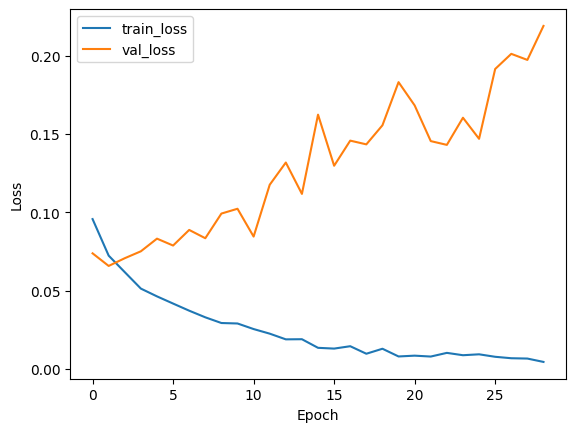

In [47]:
import matplotlib.pyplot as plt
log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(model, data_loader, best_threshold=0.5, device='cuda', criterion=None):
    trues, predictions, outputs = test_loop(model, data_loader, device=device, criterion=criterion, best_threshold=best_threshold)
    print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
    print(confusion_matrix(trues, predictions ))
    roc_auc = roc_auc_score(trues, outputs)
    print(f"ROC AUC: {roc_auc:.4f}")
    curve = roc_curve(trues, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(curve[0], curve[1], label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [ ]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
model.load_state_dict(torch.load(r'model\0811_1802\best_model.pth', weights_only=True))

<All keys matched successfully>

Performance on Training Set:
🔍 Test Loss: 0.0065 | Accuracy: 99.93%
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    292237
     Failure       0.88      0.86      0.87       840

    accuracy                           1.00    293077
   macro avg       0.94      0.93      0.94    293077
weighted avg       1.00      1.00      1.00    293077

[[292142     95]
 [   115    725]]
ROC AUC: 0.9997


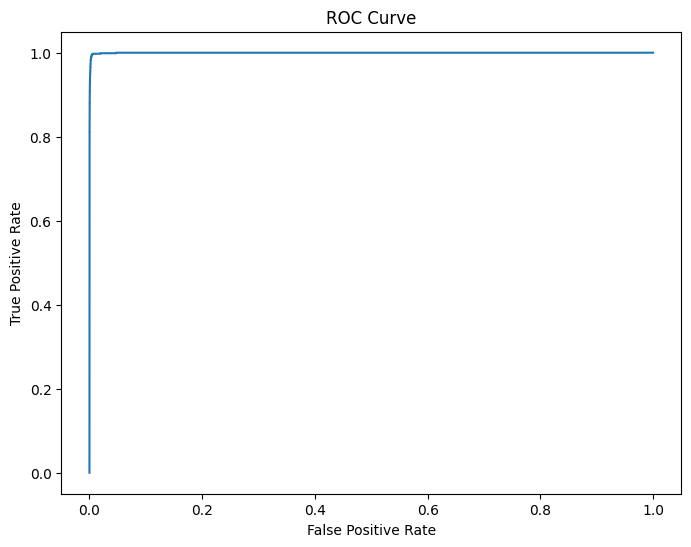

In [50]:
print("Performance on Training Set:")
evaluate_model(model, train_loader, best_threshold=0.5, device='cuda', criterion=criterion)

In [51]:
trues, predictions, outputs = test_loop(model, val_loader, device='cuda', criterion=criterion)

🔍 Test Loss: 0.2086 | Accuracy: 99.68%


In [52]:
from sklearn.metrics import precision_recall_curve, f1_score

# y_val: 驗證集真實標籤 (0/1)
# y_val_scores: 模型輸出的機率（sigmoid 後）或 logits
precisions, recalls, thresholds = precision_recall_curve(trues, outputs)

# 計算 F1
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1:", f1_scores[best_idx])


Best threshold: 2.8345794e-05
Precision: 0.011976047904191617
Recall: 0.15833333333333333
F1: 0.022267798282312696


Performance on Validation Set:
🔍 Test Loss: 0.2086 | Accuracy: 96.20%
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     87528
     Failure       0.01      0.15      0.02       240

    accuracy                           0.96     87768
   macro avg       0.50      0.56      0.50     87768
weighted avg       0.99      0.96      0.98     87768

[[84393  3135]
 [  203    37]]
ROC AUC: 0.7043


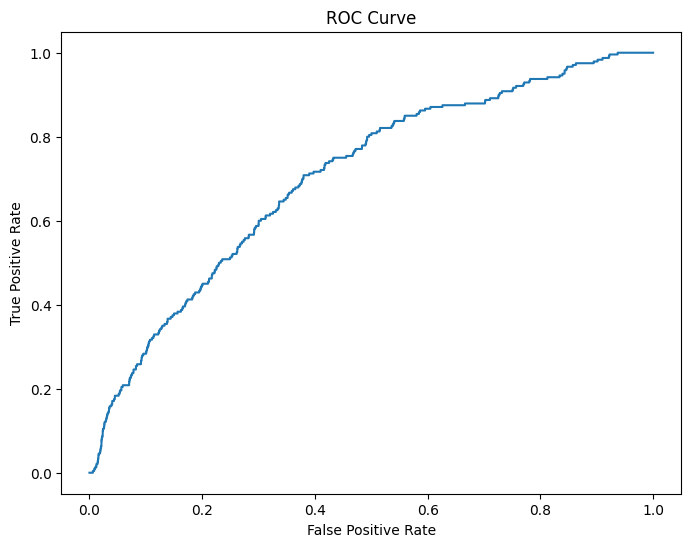

In [53]:
print("Performance on Validation Set:")
evaluate_model(model, val_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)

Performance on Test Set:
🔍 Test Loss: 2.1678 | Accuracy: 82.22%
              precision    recall  f1-score   support

      Normal       0.97      0.84      0.90     36279
     Failure       0.05      0.28      0.08      1080

    accuracy                           0.82     37359
   macro avg       0.51      0.56      0.49     37359
weighted avg       0.95      0.82      0.88     37359

[[30418  5861]
 [  780   300]]
ROC AUC: 0.5436


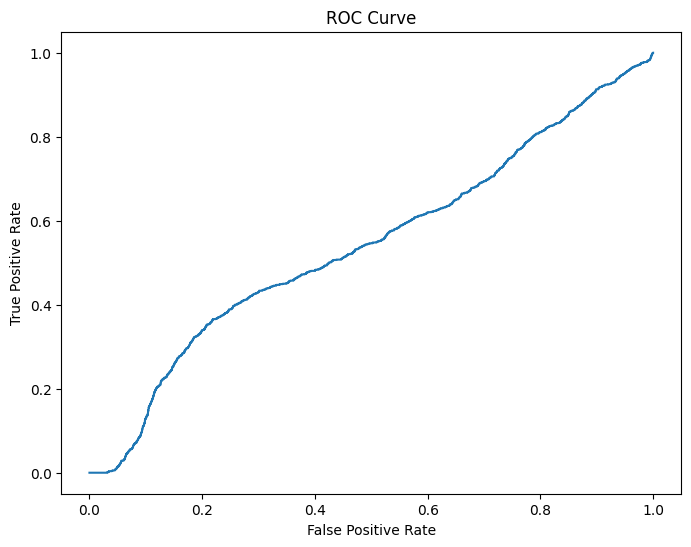

In [54]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)